<a href="https://colab.research.google.com/github/crystalclcm/JobPostings/blob/main/Examprep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Colab file upload
from google.colab import files

# Scikit-learn transformers you’ll likely need later
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler


In [2]:
# Upload: choose travel_exam_dataset.csv from your computer
uploaded = files.upload()  # no arguments


Saving travel_exam_dataset.csv to travel_exam_dataset (1).csv


In [3]:
df = pd.read_csv('/content/travel_exam_dataset (1).csv')
print(df.shape)
df.head()


(150, 11)


,booking_id,passenger_age,travel_class,origin_city,destination_city,booking_date,departure_date,ticket_price,partner,payment_status,review_text
0,1,56.0,Economy,Rome,Berlin,2023-09-28,2023-11-22,54.92,FlyNow,Failed,Great flight!
1,2,28.0,Business,Dublin,Paris,10/04/2023,2023-04-28,624.23,AirX,Paid,Terrible delay.
2,3,70.0,Business,Dublin,Paris,2023-10-21,17/10/2023,113.71,FlyNow,Pending,NaN
3,4,39.0,Economy,London,Rome,18/02/2023,12/04/2023,113.48,GoSky,Paid,Terrible delay.
4,5,45.0,Premium,Dublin,Dublin,28/09/2023,2023-11-23,197.01,GoSky,Pending,NaN


In [4]:
print(df.info())
print(df.describe(include='all'))
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   booking_id        150 non-null    int64  
 1   passenger_age     148 non-null    float64
 2   travel_class      150 non-null    object 
 3   origin_city       150 non-null    object 
 4   destination_city  150 non-null    object 
 5   booking_date      150 non-null    object 
 6   departure_date    150 non-null    object 
 7   ticket_price      150 non-null    float64
 8   partner           110 non-null    object 
 9   payment_status    150 non-null    object 
 10  review_text       89 non-null     object 
dtypes: float64(2), int64(1), object(8)
memory usage: 13.0+ KB
None
        booking_id  passenger_age travel_class origin_city destination_city  \
count   150.000000     148.000000          150         150              150   
unique         NaN            NaN            3           6

In [5]:
# Example: mean imputation for a numeric column (Q1)
# Replace 'passenger_age' with the exact column name in your dataset
df['passenger_age'] = df['passenger_age'].fillna(df['passenger_age'].mean())

# For categorical columns (e.g., 'partner'), a simple and safe choice is to fill with 'Unknown'
df['partner'] = df['partner'].fillna('Unknown')



Later, when we do transformation and feature engineering, we’ll keep everything equally simple: pd.to_datetime() for dates, OrdinalEncoder for ordered categories (if applicable), OneHotEncoder for nominal categories, StandardScaler for numeric scaling, and pd.qcut for price bands.

Q1 — Cleaning
1) Handle missing values (mean for passenger_age, simple fill for partner)

In [6]:

# Check missing first (for your notes)
print(df[['passenger_age', 'partner']].isnull().sum())

# Numeric imputation: mean for passenger_age (as per your preference)
df['passenger_age'] = df['passenger_age'].fillna(df['passenger_age'].mean())

# Categorical imputation: simple fill for partner
# We use 'Unknown' so we keep rows without guessing a specific partner.
df['partner'] = df['partner'].fillna('Unknown')

# Optional: review_text is not used for downstream numeric transforms;
# if needed for analysis, you can leave as is or fill with 'No review'.
# df['review_text'] = df['review_text'].fillna('No review')


passenger_age    0
partner          0
dtype: int64


Brief justification:
passenger_age: mean imputation is simple and matches the exam requirement; alternatives (median/mode) would be more robust to skew but are not necessary here.
partner: filling with "Unknown" preserves rows and avoids introducing false order/magnitude.

2) Convert booking_date and departure_date to datetime

In [14]:

df['booking_date']   = pd.to_datetime(df['booking_date'],   errors='coerce', dayfirst=True)
df['departure_date'] = pd.to_datetime(df['departure_date'], errors='coerce', dayfirst=True)



In [15]:
print(df[['booking_date','departure_date']].isnull().sum())
print(df.dtypes[['booking_date','departure_date']])


booking_date      70
departure_date    70
dtype: int64
booking_date      datetime64[ns]
departure_date    datetime64[ns]
dtype: object


Q2 — Transforming

In [16]:

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Ordinal encoding for travel_class (adjust the order if your data contains other labels like 'First')
class_order = [['Economy', 'Business', 'Premium']]
ord_enc = OrdinalEncoder(categories=class_order)
df['travel_class_encoded'] = ord_enc.fit_transform(df[['travel_class']])

# One-hot for partner — safe for train/test splits and avoids dummy variable trap by dropping first
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
partner_matrix = ohe.fit_transform(df[['partner']])
partner_cols = ohe.get_feature_names_out(['partner'])

# Append encoded partner columns
import pandas as pd
df_partner = pd.DataFrame(partner_matrix, columns=partner_cols, index=df.index)
df = pd.concat([df, df_partner], axis=1)

# Quick check (optional)
df.filter(like='partner_').head()


,partner_FlyNow,partner_GoSky,partner_Unknown
0,1.0,0.0,0.0
1,0.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


travel_class has a natural order; ordinal encoding preserves that order without inventing numeric magnitude beyond rank.
partner is nominal; one‑hot encoding avoids implying order and works safely with unseen categories.

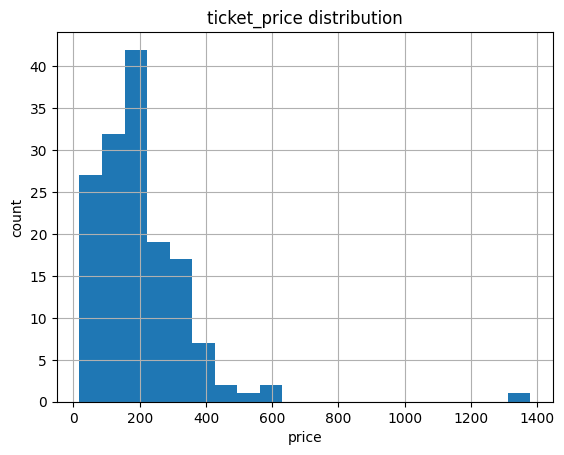

   ticket_price  ticket_price_scaled
0         54.92            -0.979327
1        624.23             2.826707
2        113.71            -0.586295
3        113.48            -0.587833
4        197.01            -0.029406


In [17]:

# Optional: quick visual to understand the distribution
import matplotlib.pyplot as plt
df['ticket_price'].hist(bins=20)
plt.title('ticket_price distribution'); plt.xlabel('price'); plt.ylabel('count'); plt.show()

# Simple scaling choice: StandardScaler (mean=0, std=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['ticket_price_scaled'] = scaler.fit_transform(df[['ticket_price']])

# Quick summary to verify scaling
print(df[['ticket_price', 'ticket_price_scaled']].head())


Short justification: Standardisation is a common default that makes features comparable in magnitude and often helps models that rely on distances or optimisation.

In [18]:

# Quantile-based bins: creates ~equal-sized groups
df['price_band'] = pd.qcut(df['ticket_price'], q=3, labels=['Low', 'Medium', 'High'])

print(df['price_band'].value_counts())
df[['ticket_price', 'price_band']].head()


price_band
Low       50
Medium    50
High      50
Name: count, dtype: int64


,ticket_price,price_band
0,54.92,Low
1,624.23,High
2,113.71,Low
3,113.48,Low
4,197.01,Medium


Short justification: qcut is robust to uneven ranges and gives clean Low/Medium/High groupings with roughly equal counts.

Q3 — Feature Engineering

In [19]:

# Will produce NaN where either date is NaT (acceptable; note this in your explanation)
df['days_between_booking_and_departure'] = (df['departure_date'] - df['booking_date']).dt.days

# Quick sanity check
print(df['days_between_booking_and_departure'].describe())


count    43.000000
mean     26.976744
std      21.504693
min      -5.000000
25%       5.500000
50%      27.000000
75%      44.000000
max      59.000000
Name: days_between_booking_and_departure, dtype: float64


In [20]:

df['departure_month'] = df['departure_date'].dt.month

# Quick sanity check
print(df['departure_month'].value_counts().sort_index())


departure_month
1.0      4
2.0      4
3.0      6
4.0      9
5.0      9
6.0      7
7.0      8
8.0     11
9.0      9
10.0     8
11.0     3
12.0     2
Name: count, dtype: int64


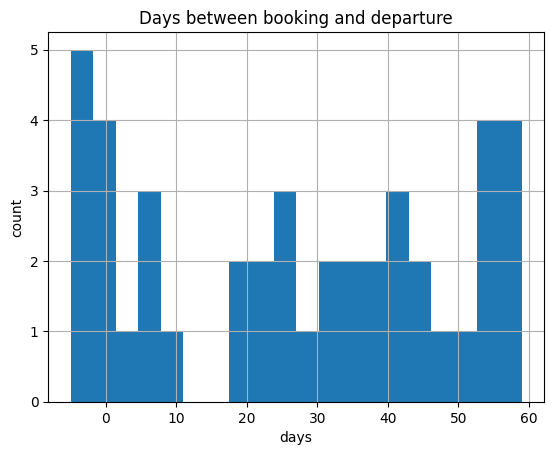

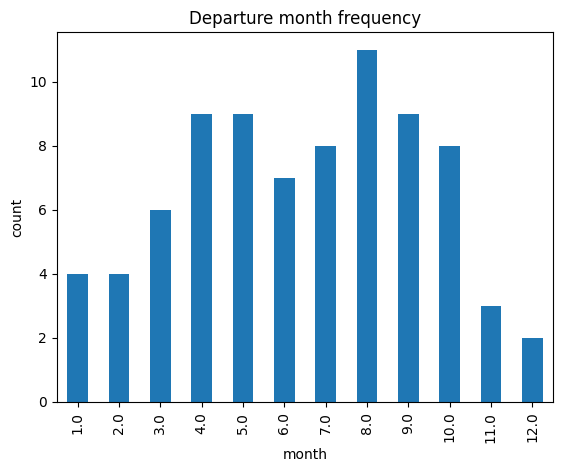

In [21]:

# Days between booking and departure
df['days_between_booking_and_departure'].hist(bins=20)
plt.title('Days between booking and departure'); plt.xlabel('days'); plt.ylabel('count'); plt.show()

# Departure month counts
df['departure_month'].value_counts().sort_index().plot(kind='bar')
plt.title('Departure month frequency'); plt.xlabel('month'); plt.ylabel('count'); plt.show()


In [22]:

# Check for any remaining issues
print(df[['travel_class_encoded', 'ticket_price_scaled', 'price_band',
          'days_between_booking_and_departure', 'departure_month']].head())

# Save the processed dataset for submission or later use
df.to_csv('/content/travel_exam_dataset_processed.csv', index=False)


   travel_class_encoded  ticket_price_scaled price_band  \
0                   0.0            -0.979327        Low   
1                   1.0             2.826707       High   
2                   1.0            -0.586295        Low   
3                   0.0            -0.587833        Low   
4                   2.0            -0.029406     Medium   

   days_between_booking_and_departure  departure_month  
0                                55.0             11.0  
1                                 NaN              4.0  
2                                 NaN              NaN  
3                                 NaN              NaN  
4                                 NaN             11.0  
